In [1]:
!git clone https://github.com/BlindDPS/blind-dps


Cloning into 'blind-dps'...
remote: Enumerating objects: 140, done.
remote: Counting objects: 100% (61/61), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 140 (delta 47), reused 46 (delta 46), pack-reused 79
Receiving objects: 100% (140/140), 642.75 KiB | 5.06 MiB/s, done.
Resolving deltas: 100% (73/73), done.


In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
pip install torch==1.11.0 torchvision==0.12.0 torchaudio==0.11.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 750.6/750.6 MB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 3.0 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.2.1+cu121
    Uninstalling torch-2.2.1+cu121:
      Successfully uninstalled torch-2.2.1+cu121
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.17.1+cu121
    Uninstalling torchvision-0.17.1+cu121:
      Successfully uninstalled torchvision-0.17.1+cu121
  Attempting uninstall: torchaudio
    Found existing installation: torchaudio 2.2.1+cu121
    Uninstalling torchaudio-2.2.1+cu121:
      Successfully uninstalled torchaudio-2.2.1+cu121
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchdata 0.7.1 requires torch>=2, but y

In [6]:
cd /content/blind-dps

/content/blind-dps


# Experiment with original paper

In [14]:
from functools import partial
import os
import argparse
import yaml

import numpy as np
import torch
import torchvision
import torchaudio
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

from guided_diffusion.blind_condition_methods import get_conditioning_method
from guided_diffusion.measurements import get_operator, get_noise
from guided_diffusion.unet import create_model
from guided_diffusion.gaussian_diffusion import create_sampler
from data.dataloader import get_dataset, get_dataloader
from motionblur.motionblur import Kernel
from util.img_utils import Blurkernel, clear_color
from util.logger import get_logger

In [16]:
def load_yaml(file_path: str) -> dict:
    with open(file_path) as f:
        config = yaml.load(f, Loader=yaml.FullLoader)
    return config

In [87]:
# Directly assigning configurations instead of using argparse
img_model_config_path = 'configs/model_config.yaml'
kernel_model_config_path = 'configs/kernel_model_config.yaml'
diffusion_config_path = 'configs/diffusion_config.yaml'
task_config_path = 'configs/motion_deblur_config.yaml'

# Training configurations
gpu = 0
save_dir = './results'

# Regularization configurations
reg_scale = 0.1
reg_ord = 0  # Assuming 0 and 1 are your only options based on the choices you provided

# logger
logger = get_logger()

# Device setting
device_str = f"cuda:{gpu}" if torch.cuda.is_available() else 'cpu'
logger.info(f"Device set to {device_str}.")
device = torch.device(device_str)

# Load configurations using your previously defined function, assuming it reads a YAML file into a dictionary
img_model_config = load_yaml(img_model_config_path)
kernel_model_config = load_yaml(kernel_model_config_path)
diffusion_config = load_yaml(diffusion_config_path)
task_config = load_yaml(task_config_path)


2024-04-10 20:15:37,684 [DPS] >> Device set to cuda:0.
2024-04-10 20:15:37,684 [DPS] >> Device set to cuda:0.
INFO:DPS:Device set to cuda:0.


In [22]:
img_model_config['model_path'] = '/content/drive/MyDrive/tien/models/ffhq_10m.pt'

In [25]:
img_model_config

{'image_size': 256,
 'num_channels': 128,
 'num_res_blocks': 1,
 'channel_mult': '',
 'learn_sigma': True,
 'class_cond': False,
 'use_checkpoint': False,
 'attention_resolutions': 16,
 'num_heads': 4,
 'num_head_channels': 64,
 'num_heads_upsample': -1,
 'use_scale_shift_norm': True,
 'dropout': 0.0,
 'resblock_updown': True,
 'use_fp16': False,
 'use_new_attention_order': False,
 'model_path': '/content/drive/MyDrive/tien/models/ffhq_10m.pt'}

In [23]:
kernel_model_config['model_path'] = '/content/drive/MyDrive/tien/models/kernel_checkpoint.pt'

In [26]:
kernel_model_config

{'image_size': 64,
 'num_channels': 64,
 'num_res_blocks': 1,
 'channel_mult': '',
 'learn_sigma': True,
 'class_cond': False,
 'use_checkpoint': False,
 'attention_resolutions': 16,
 'num_heads': 4,
 'num_head_channels': 64,
 'num_heads_upsample': -1,
 'use_scale_shift_norm': True,
 'dropout': 0.0,
 'resblock_updown': True,
 'use_fp16': False,
 'use_new_attention_order': False,
 'grayscale': True,
 'model_path': '/content/drive/MyDrive/tien/models/kernel_checkpoint.pt'}

In [27]:
# Load model
img_model = create_model(**img_model_config)
img_model = img_model.to(device)
img_model.eval()
kernel_model = create_model(**kernel_model_config)
kernel_model = kernel_model.to(device)
kernel_model.eval()
model = {'img': img_model, 'kernel': kernel_model}

In [28]:
# Prepare Operator and noise
measure_config = task_config['measurement']
operator = get_operator(device=device, **measure_config['operator'])
noiser = get_noise(**measure_config['noise'])
logger.info(f"Operation: {measure_config['operator']['name']} / Noise: {measure_config['noise']['name']}")


2024-04-10 19:30:50,041 [DPS] >> Operation: blind_blur / Noise: gaussian
INFO:DPS:Operation: blind_blur / Noise: gaussian


In [29]:
  # Prepare Operator and noise
measure_config = task_config['measurement']
operator = get_operator(device=device, **measure_config['operator'])
noiser = get_noise(**measure_config['noise'])
logger.info(f"Operation: {measure_config['operator']['name']} / Noise: {measure_config['noise']['name']}")


2024-04-10 19:30:50,058 [DPS] >> Operation: blind_blur / Noise: gaussian
INFO:DPS:Operation: blind_blur / Noise: gaussian


In [30]:
cond_config = task_config['conditioning']
cond_method = get_conditioning_method(cond_config['method'], operator, noiser, **cond_config['params'])
logger.info(f"Conditioning method : {task_config['conditioning']['method']}")
measurement_cond_fn = cond_method.conditioning

2024-04-10 19:30:50,070 [DPS] >> Conditioning method : ps
INFO:DPS:Conditioning method : ps


In [31]:
## add regularization
regularization = {'kernel': (0, 0.1)}
measurement_cond_fn = partial(measurement_cond_fn, regularization=regularization)

In [32]:
 # Load diffusion sampler
sampler = create_sampler(**diffusion_config)
sample_fn = partial(sampler.p_sample_loop, model=model, measurement_cond_fn=measurement_cond_fn)

In [33]:
# Prepare dataloader
data_config = task_config['data']
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
dataset = get_dataset(**data_config, transforms=transform)
loader = get_dataloader(dataset, batch_size=1, num_workers=0, train=False)

In [34]:
for i, ref_img in enumerate(loader):
  ref_img = ref_img.to(device)

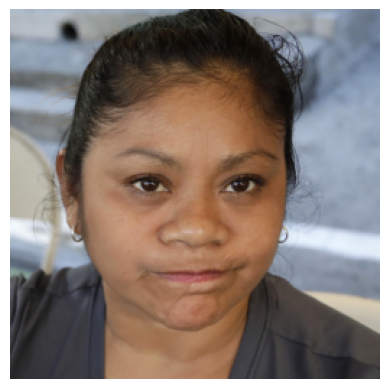

In [35]:
import matplotlib.pyplot as plt
import torch

# Display the image using matplotlib
plt.imshow(clear_color(ref_img))
plt.axis('off')  # Hide axis
plt.show()

In [36]:
## create kernel

if task_config["kernel"] == 'motion':
  kernel = Kernel(size=(task_config["kernel_size"], task_config["kernel_size"]), intensity=task_config["intensity"]).kernelMatrix
  kernel = torch.from_numpy(kernel).type(torch.float32)
  kernel = kernel.to(device).view(1, 1, task_config["kernel_size"], task_config["kernel_size"])
elif task_config["kernel"] == 'gaussian':
  conv = Blurkernel('gaussian', kernel_size=task_config["kernel_size"], device=device)
  kernel = conv.get_kernel().type(torch.float32)
  kernel = kernel.to(device).view(1, 1, task_config["kernel_size"], task_config["kernel_size"])

In [37]:
## Degrade image

y = operator.forward(ref_img, kernel)
y_n = noiser(y)

/content/blind-dps/guided_diffusion/measurements.py:170: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ../aten/src/ATen/native/Convolution.cpp:744.)
  b_img[:, i, :, :] = F.conv2d(data[:, i:i+1, :, :], kernel, padding='same')


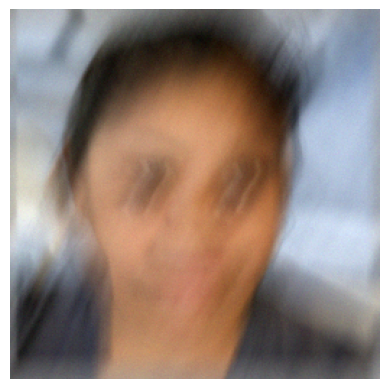

In [38]:
import matplotlib.pyplot as plt
import torch

# Display the image using matplotlib
plt.imshow(clear_color(y_n))
plt.axis('off')  # Hide axis
plt.show()

In [39]:
## Blind DPS algorithm

x_start = {'img': torch.randn(ref_img.shape, device=device).requires_grad_(),
            'kernel': torch.randn(kernel.shape, device=device).requires_grad_()}

for k in x_start:
  if k in model.keys():
    logger.info(f"{k} will use diffusion prior")
  else:
    logger.info(f"{k} will use uniform prior.")



# sample
sample = sample_fn(x_start=x_start, measurement=y_n, record=False, save_root=None)

2024-04-10 19:30:57,996 [DPS] >> img will use diffusion prior
INFO:DPS:img will use diffusion prior
2024-04-10 19:30:58,000 [DPS] >> kernel will use diffusion prior
INFO:DPS:kernel will use diffusion prior


  0%|          | 0/1000 [00:00<?, ?it/s]

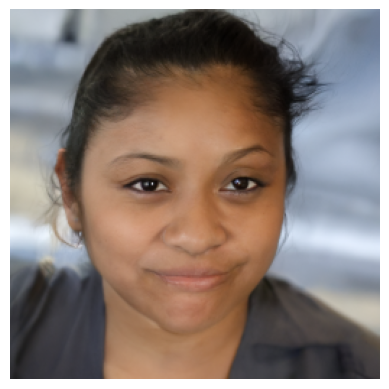

In [40]:
import matplotlib.pyplot as plt
import torch

# Display the image using matplotlib
plt.imshow(clear_color(sample['img']))
plt.axis('off')  # Hide axis
plt.show()

# Experiment with different diffusion model

In [41]:
img_model_config['model_path'] = '/content/drive/MyDrive/tien/models/metface_p2.pt'

In [42]:
img_model_config

{'image_size': 256,
 'num_channels': 128,
 'num_res_blocks': 1,
 'channel_mult': '',
 'learn_sigma': True,
 'class_cond': False,
 'use_checkpoint': False,
 'attention_resolutions': 16,
 'num_heads': 4,
 'num_head_channels': 64,
 'num_heads_upsample': -1,
 'use_scale_shift_norm': True,
 'dropout': 0.0,
 'resblock_updown': True,
 'use_fp16': False,
 'use_new_attention_order': False,
 'model_path': '/content/drive/MyDrive/tien/models/metface_p2.pt'}

In [43]:
# Load model
img_model = create_model(**img_model_config)
img_model = img_model.to(device)
img_model.eval()
kernel_model = create_model(**kernel_model_config)
kernel_model = kernel_model.to(device)
kernel_model.eval()
model = {'img': img_model, 'kernel': kernel_model}

In [44]:
## Degrade image

y = operator.forward(ref_img, kernel)
y_n = noiser(y)

In [46]:
## Blind DPS algorithm

x_start = {'img': torch.randn(ref_img.shape, device=device).requires_grad_(),
            'kernel': torch.randn(kernel.shape, device=device).requires_grad_()}

for k in x_start:
  if k in model.keys():
    logger.info(f"{k} will use diffusion prior")
  else:
    logger.info(f"{k} will use uniform prior.")



# sample
sample = sample_fn(x_start=x_start, measurement=y_n, record=False, save_root=None)

2024-04-10 19:42:46,485 [DPS] >> img will use diffusion prior
INFO:DPS:img will use diffusion prior
2024-04-10 19:42:46,490 [DPS] >> kernel will use diffusion prior
INFO:DPS:kernel will use diffusion prior


  0%|          | 0/1000 [00:00<?, ?it/s]

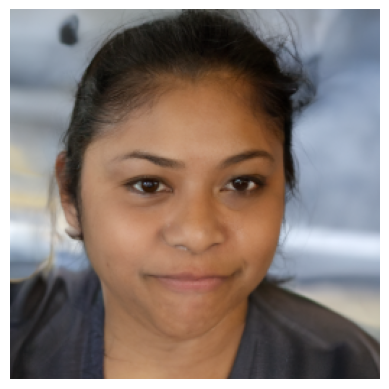

In [47]:
import matplotlib.pyplot as plt
import torch

# Display the image using matplotlib
plt.imshow(clear_color(sample['img']))
plt.axis('off')  # Hide axis
plt.show()

In [48]:
img_model_config['model_path'] = '/content/drive/MyDrive/tien/models/afhqdog_p2.pt'

In [51]:
img_model_config

{'image_size': 256,
 'num_channels': 128,
 'num_res_blocks': 1,
 'channel_mult': '',
 'learn_sigma': True,
 'class_cond': False,
 'use_checkpoint': False,
 'attention_resolutions': 16,
 'num_heads': 4,
 'num_head_channels': 64,
 'num_heads_upsample': -1,
 'use_scale_shift_norm': True,
 'dropout': 0.0,
 'resblock_updown': True,
 'use_fp16': False,
 'use_new_attention_order': False,
 'model_path': '/content/drive/MyDrive/tien/models/afhqdog_p2.pt'}

In [52]:
# Load model
img_model = create_model(**img_model_config)
img_model = img_model.to(device)
img_model.eval()
kernel_model = create_model(**kernel_model_config)
kernel_model = kernel_model.to(device)
kernel_model.eval()
model = {'img': img_model, 'kernel': kernel_model}

In [53]:
## Degrade image

y = operator.forward(ref_img, kernel)
y_n = noiser(y)

In [54]:
## Blind DPS algorithm

x_start = {'img': torch.randn(ref_img.shape, device=device).requires_grad_(),
            'kernel': torch.randn(kernel.shape, device=device).requires_grad_()}

for k in x_start:
  if k in model.keys():
    logger.info(f"{k} will use diffusion prior")
  else:
    logger.info(f"{k} will use uniform prior.")


# sample
sample = sample_fn(x_start=x_start, measurement=y_n, record=False, save_root=None)

2024-04-10 19:52:05,187 [DPS] >> img will use diffusion prior
INFO:DPS:img will use diffusion prior
2024-04-10 19:52:05,190 [DPS] >> kernel will use diffusion prior
INFO:DPS:kernel will use diffusion prior


  0%|          | 0/1000 [00:00<?, ?it/s]

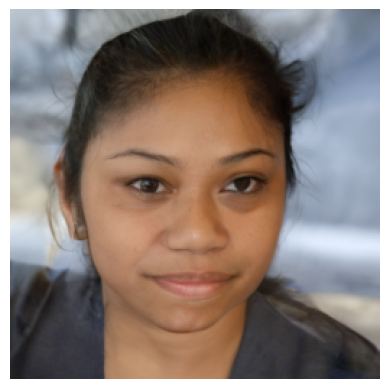

In [55]:
import matplotlib.pyplot as plt
import torch

# Display the image using matplotlib
plt.imshow(clear_color(sample['img']))
plt.axis('off')  # Hide axis
plt.show()

# Experiment with diffent setting

In [62]:
task_config["kernel"] = 'gaussian'

In [63]:
## create kernel

if task_config["kernel"] == 'motion':
  kernel = Kernel(size=(task_config["kernel_size"], task_config["kernel_size"]), intensity=task_config["intensity"]).kernelMatrix
  kernel = torch.from_numpy(kernel).type(torch.float32)
  kernel = kernel.to(device).view(1, 1, task_config["kernel_size"], task_config["kernel_size"])
elif task_config["kernel"] == 'gaussian':
  conv = Blurkernel('gaussian', kernel_size=task_config["kernel_size"], device=device)
  kernel = conv.get_kernel().type(torch.float32)
  kernel = kernel.to(device).view(1, 1, task_config["kernel_size"], task_config["kernel_size"])

In [64]:
img_model_config['model_path'] = '/content/drive/MyDrive/tien/models/ffhq_10m.pt'

In [65]:
img_model_config

{'image_size': 256,
 'num_channels': 128,
 'num_res_blocks': 1,
 'channel_mult': '',
 'learn_sigma': True,
 'class_cond': False,
 'use_checkpoint': False,
 'attention_resolutions': 16,
 'num_heads': 4,
 'num_head_channels': 64,
 'num_heads_upsample': -1,
 'use_scale_shift_norm': True,
 'dropout': 0.0,
 'resblock_updown': True,
 'use_fp16': False,
 'use_new_attention_order': False,
 'model_path': '/content/drive/MyDrive/tien/models/ffhq_10m.pt'}

In [66]:
# Load model
img_model = create_model(**img_model_config)
img_model = img_model.to(device)
img_model.eval()
kernel_model = create_model(**kernel_model_config)
kernel_model = kernel_model.to(device)
kernel_model.eval()
model = {'img': img_model, 'kernel': kernel_model}

In [67]:
## Degrade image

y = operator.forward(ref_img, kernel)
y_n = noiser(y)

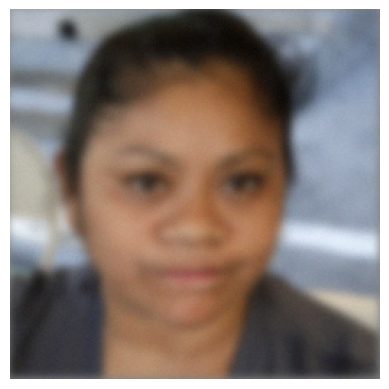

In [68]:
import matplotlib.pyplot as plt
import torch

# Display the image using matplotlib
plt.imshow(clear_color(y_n))
plt.axis('off')  # Hide axis
plt.show()

In [69]:
## Blind DPS algorithm

x_start = {'img': torch.randn(ref_img.shape, device=device).requires_grad_(),
            'kernel': torch.randn(kernel.shape, device=device).requires_grad_()}

for k in x_start:
  if k in model.keys():
    logger.info(f"{k} will use diffusion prior")
  else:
    logger.info(f"{k} will use uniform prior.")


# sample
sample = sample_fn(x_start=x_start, measurement=y_n, record=False, save_root=None)

2024-04-10 20:02:20,081 [DPS] >> img will use diffusion prior
INFO:DPS:img will use diffusion prior
2024-04-10 20:02:20,093 [DPS] >> kernel will use diffusion prior
INFO:DPS:kernel will use diffusion prior


  0%|          | 0/1000 [00:00<?, ?it/s]

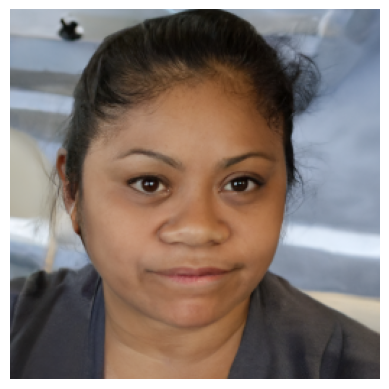

In [70]:
import matplotlib.pyplot as plt
import torch

# Display the image using matplotlib
plt.imshow(clear_color(sample['img']))
plt.axis('off')  # Hide axis
plt.show()

# Experiment with Alarmire dataset


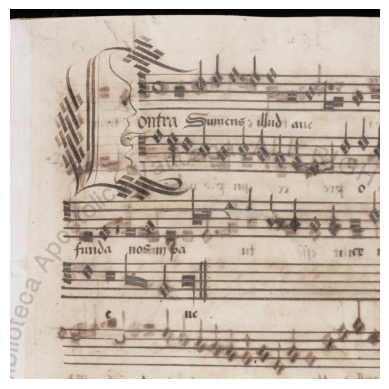

In [75]:
from PIL import Image

# Open the image file
img = Image.open('/content/drive/MyDrive/tien/Capp.Sist.15_0089_fa_0043r_m.jpg')  # Replace with your image path

# Define the coordinates of the rectangle you want to crop
# The box is a 4-tuple defining the left, upper, right, and lower pixel coordinate.
left = 300
top = 226
right = 1324
bottom = 1250
crop_box = (left, top, right, bottom)

# Crop the image and show it
img = img.crop(crop_box)
# Resize the cropped image to 1024x1024
# resized_image = cropped_image.resize((1024, 1024))

# Display the resized image using matplotlib
plt.imshow(img)
plt.axis('off')  # Hide the axis
plt.show()

In [90]:
from PIL import Image
import os

# Define the directory to save the cropped images. Make sure it exists.
output_dir = '/content/blind-dps/data/samples'  # Update this to your desired directory
os.makedirs(output_dir, exist_ok=True)

# Image dimensions and desired crop size
original_width, original_height = img.size
crop_size = 256

# Coordinates for the 4 crops (top-left corners)
crop_coordinates = [(x * crop_size, y * crop_size) for y in range(4) for x in range(4)]


# Iterate over the coordinates and perform the crops
for i, (x, y) in enumerate(crop_coordinates):
    # Define the crop box
    crop_box = (x, y, x + crop_size, y + crop_size)

    # Perform the crop
    cropped_image = img.crop(crop_box)

    # Save the cropped image
    cropped_image_path = os.path.join(output_dir, f'cropped_image_{i+1}.png')
    cropped_image.save(cropped_image_path, 'PNG')
    print(f'Saved: {cropped_image_path}')


Saved: /content/blind-dps/data/samples/cropped_image_1.png
Saved: /content/blind-dps/data/samples/cropped_image_2.png
Saved: /content/blind-dps/data/samples/cropped_image_3.png
Saved: /content/blind-dps/data/samples/cropped_image_4.png
Saved: /content/blind-dps/data/samples/cropped_image_5.png
Saved: /content/blind-dps/data/samples/cropped_image_6.png
Saved: /content/blind-dps/data/samples/cropped_image_7.png
Saved: /content/blind-dps/data/samples/cropped_image_8.png
Saved: /content/blind-dps/data/samples/cropped_image_9.png
Saved: /content/blind-dps/data/samples/cropped_image_10.png
Saved: /content/blind-dps/data/samples/cropped_image_11.png
Saved: /content/blind-dps/data/samples/cropped_image_12.png
Saved: /content/blind-dps/data/samples/cropped_image_13.png
Saved: /content/blind-dps/data/samples/cropped_image_14.png
Saved: /content/blind-dps/data/samples/cropped_image_15.png
Saved: /content/blind-dps/data/samples/cropped_image_16.png


In [94]:
# Prepare dataloader
data_config = task_config['data']
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
dataset = get_dataset(**data_config, transforms=transform)
loader = get_dataloader(dataset, batch_size=1, num_workers=0, train=False)

In [95]:
for i, ref_img in enumerate(loader):
  ref_img = ref_img.to(device)

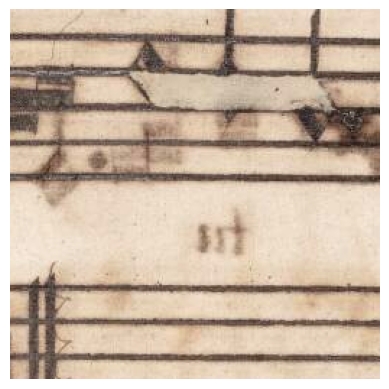

In [96]:
import matplotlib.pyplot as plt
import torch

# Display the image using matplotlib
plt.imshow(clear_color(ref_img))
plt.axis('off')  # Hide axis
plt.show()

In [97]:
task_config["kernel"] = 'motion'

In [98]:
## create kernel

if task_config["kernel"] == 'motion':
  kernel = Kernel(size=(task_config["kernel_size"], task_config["kernel_size"]), intensity=task_config["intensity"]).kernelMatrix
  kernel = torch.from_numpy(kernel).type(torch.float32)
  kernel = kernel.to(device).view(1, 1, task_config["kernel_size"], task_config["kernel_size"])
elif task_config["kernel"] == 'gaussian':
  conv = Blurkernel('gaussian', kernel_size=task_config["kernel_size"], device=device)
  kernel = conv.get_kernel().type(torch.float32)
  kernel = kernel.to(device).view(1, 1, task_config["kernel_size"], task_config["kernel_size"])

In [99]:
img_model_config['model_path'] = '/content/drive/MyDrive/tien/models/ffhq_10m.pt'

In [100]:
img_model_config

{'image_size': 256,
 'num_channels': 128,
 'num_res_blocks': 1,
 'channel_mult': '',
 'learn_sigma': True,
 'class_cond': False,
 'use_checkpoint': False,
 'attention_resolutions': 16,
 'num_heads': 4,
 'num_head_channels': 64,
 'num_heads_upsample': -1,
 'use_scale_shift_norm': True,
 'dropout': 0.0,
 'resblock_updown': True,
 'use_fp16': False,
 'use_new_attention_order': False,
 'model_path': '/content/drive/MyDrive/tien/models/ffhq_10m.pt'}

In [101]:
## Degrade image

y = operator.forward(ref_img, kernel)
y_n = noiser(y)

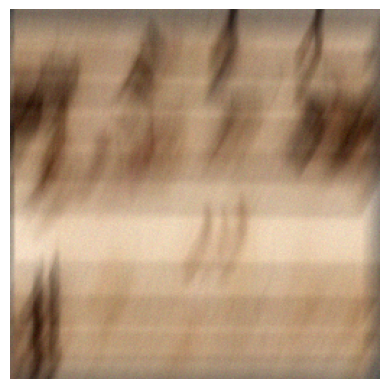

In [102]:
import matplotlib.pyplot as plt
import torch

# Display the image using matplotlib
plt.imshow(clear_color(y_n))
plt.axis('off')  # Hide axis
plt.show()

In [103]:
## Blind DPS algorithm

x_start = {'img': torch.randn(ref_img.shape, device=device).requires_grad_(),
            'kernel': torch.randn(kernel.shape, device=device).requires_grad_()}

for k in x_start:
  if k in model.keys():
    logger.info(f"{k} will use diffusion prior")
  else:
    logger.info(f"{k} will use uniform prior.")


# sample
sample = sample_fn(x_start=x_start, measurement=y_n, record=False, save_root=None)

2024-04-10 20:21:42,477 [DPS] >> img will use diffusion prior
2024-04-10 20:21:42,477 [DPS] >> img will use diffusion prior
INFO:DPS:img will use diffusion prior
2024-04-10 20:21:42,484 [DPS] >> kernel will use diffusion prior
2024-04-10 20:21:42,484 [DPS] >> kernel will use diffusion prior
INFO:DPS:kernel will use diffusion prior


  0%|          | 0/1000 [00:00<?, ?it/s]

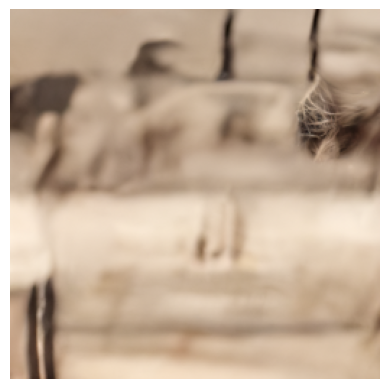

In [104]:
import matplotlib.pyplot as plt
import torch

# Display the image using matplotlib
plt.imshow(clear_color(sample['img']))
plt.axis('off')  # Hide axis
plt.show()

## Experiment with the original Alarmire dataset

In [105]:
## Blind DPS algorithm

x_start = {'img': torch.randn(ref_img.shape, device=device).requires_grad_(),
            'kernel': torch.randn(kernel.shape, device=device).requires_grad_()}

for k in x_start:
  if k in model.keys():
    logger.info(f"{k} will use diffusion prior")
  else:
    logger.info(f"{k} will use uniform prior.")


# sample
sample = sample_fn(x_start=x_start, measurement=ref_img, record=False, save_root=None)

2024-04-10 20:28:35,943 [DPS] >> img will use diffusion prior
2024-04-10 20:28:35,943 [DPS] >> img will use diffusion prior
INFO:DPS:img will use diffusion prior
2024-04-10 20:28:35,952 [DPS] >> kernel will use diffusion prior
2024-04-10 20:28:35,952 [DPS] >> kernel will use diffusion prior
INFO:DPS:kernel will use diffusion prior


  0%|          | 0/1000 [00:00<?, ?it/s]

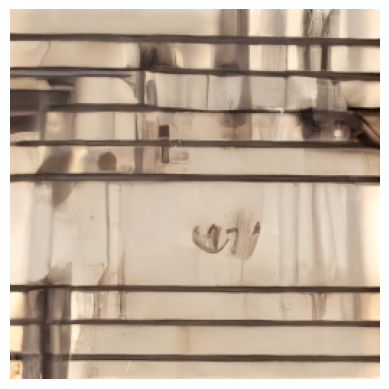

In [106]:
import matplotlib.pyplot as plt
import torch

# Display the image using matplotlib
plt.imshow(clear_color(sample['img']))
plt.axis('off')  # Hide axis
plt.show()